In [1]:
pip install tensorflow keras numpy pandas matplotlib scikit-learn seaborn jupyterlab streamlit pillow

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.2-py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/332.0 MB 5.3 MB/s eta 0:01:03
   ---------------------------------------- 1.8/332.0 MB 5.8 MB/s eta 0:00:58
   ---------------------------------------- 3.1/332.0 MB 5.7 MB/s eta 0:00:58
    --------------------------------------- 4.2/332.0 MB 5.7 MB/s eta 0:00:58
    --------------------------------------- 5.5/332.0 MB 5.6 MB/s eta 0:00:58
    --------------------------------------- 6.6/332.0 MB 5.7 MB/s eta 0:00:58
    --------------------------------------- 7.9/332.0 MB 5.6 MB/s eta 0:00:59
    --------------------------------------- 8.1/332.0 MB 5.6 MB/s eta 0:00:59
    --------------------------------------- 8.1/332.0 MB 5.6 MB/s eta 0:00:59
    --------------------------------------- 8.1/332.0 MB 5.6 MB/s eta 0:00:59
    -------

In [50]:
#Step 2: Import libraries and load data
# train_all_models.py

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os


# --- Step 1: Setup paths ---
train_dir = "C:/Ganapathy/Proj 5/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/train" 
val_dir = "C:/Ganapathy/Proj 5/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/val"

os.makedirs("models", exist_ok=True)

# --- Step 2: Convert Grayscale to RGB ---
def to_rgb(x):
    if x.shape[-1] == 1:
        x = np.repeat(x, 3, axis=-1)
    return x

# --- Step 3: Data Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=to_rgb
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=to_rgb
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

num_classes = len(train_data.class_indices)

# --- Step 4: Build CNN Model ---
def build_cnn(num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# --- Step 5: Build Transfer Learning Models ---
def build_transfer_model(base_model, num_classes):
    for layer in base_model.layers:
        layer.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# --- Step 6: Build Models Dictionary ---
models_dict = {
    'CNN': build_cnn(num_classes=num_classes),
    'VGG16': build_transfer_model(VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)), num_classes),
    'ResNet50': build_transfer_model(ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3)), num_classes),
    'MobileNetV2': build_transfer_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)), num_classes),
    'InceptionV3': build_transfer_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3)), num_classes)
}

# --- Step 7: Train, Evaluate, and Save Models ---
results = {}

for name, model in models_dict.items():
    print(f"\n🔹 Training {name} model...")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=3,  # Use higher epochs later (e.g., 10–20)
        verbose=1
    )

    val_loss, val_acc = model.evaluate(val_data)
    results[name] = val_acc
    model.save(f"models/{name}_model.h5")
    print(f"✅ {name} model saved successfully! Validation Accuracy: {val_acc:.4f}")

# --- Step 8: Summary ---
print("\n📊 Model Accuracy Summary:")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.

🔹 Training CNN model...
Epoch 1/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 176s 889ms/step - accuracy: 0.2826 - loss: 2.0175 - val_accuracy: 0.3965 - val_loss: 1.6773
Epoch 2/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 1384s 7s/step - accuracy: 0.3777 - loss: 1.7021 - val_accuracy: 0.4634 - val_loss: 1.4644
Epoch 3/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 963s 5s/step - accuracy: 0.4781 - loss: 1.4181 - val_accuracy: 0.6566 - val_loss: 1.0487
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - accuracy: 0.6566 - loss: 1.0487


✅ CNN model saved successfully! Validation Accuracy: 0.6566

🔹 Training VGG16 model...
Epoch 1/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 949s 5s/step - accuracy: 0.3839 - loss: 1.8480 - val_accuracy: 0.6374 - val_loss: 1.3692
Epoch 2/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 856s 4s/step - accuracy: 0.6029 - loss: 1.2625 - val_accuracy: 0.7830 - val_loss: 0.9431
Epoch 3/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 1399s 7s/step - accuracy: 0.6794 - loss: 1.0000 - val_accuracy: 0.8535 - val_loss: 0.7073
35/35 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.8535 - loss: 0.7073


✅ VGG16 model saved successfully! Validation Accuracy: 0.8535

🔹 Training ResNet50 model...
Epoch 1/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.1581 - loss: 2.3335 - val_accuracy: 0.1712 - val_loss: 2.2615
Epoch 2/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.1783 - loss: 2.2652 - val_accuracy: 0.1685 - val_loss: 2.2032
Epoch 3/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.1833 - loss: 2.2236 - val_accuracy: 0.1703 - val_loss: 2.1929
35/35 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.1703 - loss: 2.1929


✅ ResNet50 model saved successfully! Validation Accuracy: 0.1703

🔹 Training MobileNetV2 model...
Epoch 1/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 164s 823ms/step - accuracy: 0.7764 - loss: 0.7200 - val_accuracy: 0.9560 - val_loss: 0.1854
Epoch 2/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 159s 815ms/step - accuracy: 0.9137 - loss: 0.2791 - val_accuracy: 0.9661 - val_loss: 0.1085
Epoch 3/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 161s 825ms/step - accuracy: 0.9351 - loss: 0.1948 - val_accuracy: 0.9716 - val_loss: 0.0802
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 530ms/step - accuracy: 0.9716 - loss: 0.0802


✅ MobileNetV2 model saved successfully! Validation Accuracy: 0.9716

🔹 Training InceptionV3 model...
Epoch 1/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.6493 - loss: 1.0618 - val_accuracy: 0.9011 - val_loss: 0.3694
Epoch 2/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8093 - loss: 0.5553 - val_accuracy: 0.9451 - val_loss: 0.2156
Epoch 3/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8541 - loss: 0.4399 - val_accuracy: 0.9441 - val_loss: 0.2022
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 800ms/step - accuracy: 0.9441 - loss: 0.2022


✅ InceptionV3 model saved successfully! Validation Accuracy: 0.9441

📊 Model Accuracy Summary:
CNN: 0.6566
VGG16: 0.8535
ResNet50: 0.1703
MobileNetV2: 0.9716
InceptionV3: 0.9441


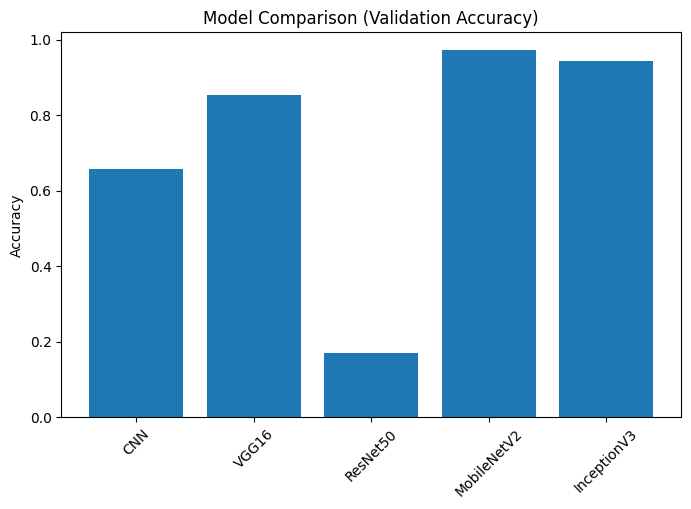

🏆 Best Model: MobileNetV2 with accuracy 0.9716


In [51]:
#step 6:Compare Model Accuracies
plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values())
plt.xticks(rotation=45)
plt.title("Model Comparison (Validation Accuracy)")
plt.ylabel("Accuracy")
plt.show()

best_model_name = max(results, key=results.get)
print(f"🏆 Best Model: {best_model_name} with accuracy {results[best_model_name]:.4f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 597ms/step
Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.13      0.14      0.14       187
                animal fish bass       0.00      0.00      0.00        10
   fish sea_food black_sea_sprat       0.12      0.12      0.12       105
   fish sea_food gilt_head_bream       0.14      0.14      0.14        94
   fish sea_food hourse_mackerel       0.11      0.11      0.11        97
        fish sea_food red_mullet       0.11      0.11      0.11        90
     fish sea_food red_sea_bream       0.10      0.10      0.10       113
          fish sea_food sea_bass       0.09      0.09      0.09        97
            fish sea_food shrimp       0.07      0.08      0.08       100
fish sea_food striped_red_mullet       0.14      0.12      0.13       101
             fish sea_food trout       0.04      0.04      0.04        98

                        accuracy             

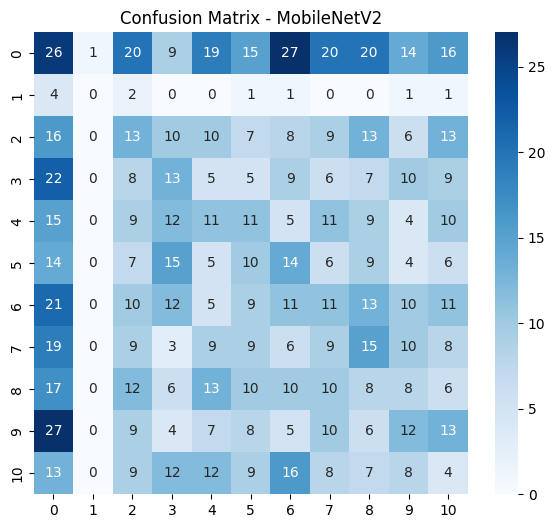

In [52]:
#step 7:Evalute Best Model
best_model = tf.keras.models.load_model(f'models/{best_model_name}_model.h5')
val_preds = best_model.predict(val_data)
y_pred = np.argmax(val_preds, axis=1)

print("Classification Report:")
print(classification_report(val_data.classes, y_pred, target_names=list(train_data.class_indices.keys())))

cm = confusion_matrix(val_data.classes, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

# Save best model separately
best_model.save("models/best_model.h5")
